# Arthropod classification + detection
Arthropods are a wide group of animals, comprising the major part of classified species. 
Arthropods are the most successful group found in almost all biogeographical regions and ecological zones and have a dominating influence on other elements of biodiversity. 
Arthropods contribute to human food supply, pollinate crops, help maintain ecosystem sustainability by biologically suppressing destructive arthropods, however, they can transmit diseases to humans and livestock, and cause crop losses. Invasive arthropods can negatively impact natural resources.
They are distinguished by their joint limbs and exoskeleton made of chitin.

### Settings

We are going to use the following libraries:

In [8]:
from PIL import Image
import torch
from torchvision import transforms
import pandas as pd
import os
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import json
from tqdm import tqdm

And the following dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive/MyDrive/'

We encountered the issue regarding the different image dimensions and aspect ratios.

Arthropoda Taxonomy Orders

This dataset contains images of (real) arthropods, where objects are labelled according to taxonomic orders.
Labels are systematic names, and their meaning are:
* Araneae: spiders;
* Coleoptera: beetles;
* Diptera: true flies, wich include mosquitoes, midges, crane flies, etc;
* Hemiptera: true bugs, which include aphids, cicadas, planthoppers, shield bugs, etc;
* Hymenoptera: ants, bees and wasps;
* Lepidoptera: butterflies and moths;
* Odonata: dragonflies and damselflies;

In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
#!pip install albumentations --quiet
!pip install albumentations==0.4.6
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

     |████████████████████████████████| 117 kB 26.3 MB/s 
     |████████████████████████████████| 948 kB 51.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=cc072959a48f3e956bb05be8ac87a121e9e9a7aad3784ab8de91a5233a71811e
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Cloning into 'vision'...
remote: Enumerating objects: 68495, done.
remote: Counting objects: 100% (3556/3556), done.
remote: Compressing objects: 100% (337/337), done.
remote: Total 68495 (delta 3229), reused 3475 (delta 3201), pack-reuse

In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
#from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
'''
import os, os.path

# simple version for working with CWD
names = [name for name in os.listdir(path + 'annotations')]
for i in range(len(names)):
  with open(path + 'annotations/' + names[i], 'r') as json_file:
    d = json.load(json_file)
    try:
      new_name = d['asset']['name'][:-4]
      os.rename(path + 'annotations/' + names[i], path + 'annotations/' + new_name + '.json')
    except:
      print(names[i])
      pass
'''

In [ ]:
'''
with open(path + 'annotations/annotations_aranae/' + '0ab50040b5a3.json', 'r') as json_file:
  d = json.load(json_file)
  print(d['regions'][0]['tags'])
  print(d['regions'][0]['points'][2]['x'])
  print(d['asset']['name'][:-4])
'''

In [ ]:
# defining the files directory and testing directory
files_dir = path + 'Images'
#test_dir = '../input/fruit-images-for-object-detection/test_zip/test'

insect_classes = [_, 'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata']
class InsectImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.l = os.listdir(files_dir)
        #random.shuffle(self.l)
        self.imgs = [image for image in sorted(self.l)#[:2100]
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        with open(path + 'annotations/' + img_name[:-4] + '.json', 'r') as json_file:
          d = json.load(json_file)
        #annot_filename = img_name[:-4] + '.xml'
        #annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        #tree = et.parse(annot_file_path)
        #root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        #for member in root.findall('object'):
            #labels.append(self.classes.index(member.find('name').text))
        labels.append(self.classes.index(d['regions'][0]['tags'][0]))
            
            # bounding box
            #xmin = int(member.find('bndbox').find('xmin').text)
        xmin = int(d['regions'][0]['points'][0]['x'])
            #xmax = int(member.find('bndbox').find('xmax').text)
        xmax = int(d['regions'][0]['points'][2]['x'])
            
            #ymin = int(member.find('bndbox').find('ymin').text)
        ymin = int(d['regions'][0]['points'][0]['y'])
            #ymax = int(member.find('bndbox').find('ymax').text)
        ymax = int(d['regions'][0]['points'][2]['y'])
            
            
        xmin_corr = (xmin/wt)*self.width
        xmax_corr = (xmax/wt)*self.width
        ymin_corr = (ymin/ht)*self.height
        ymax_corr = (ymax/ht)*self.height
            
        boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)




In [ ]:
'''
# check dataset
dataset = InsectImagesDataset(files_dir, 512, 512)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[0]
print(img.shape, '\n',target)
'''

"\n# check dataset\ndataset = InsectImagesDataset(files_dir, 512, 512)\nprint('length of dataset = ', len(dataset), '\n')\n\n# getting the image and target for a test index.  Feel free to change the index.\nimg, target = dataset[0]\nprint(img.shape, '\n',target)\n"

In [ ]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    count = 0
    indices = [target['labels'][i].item() for i in range(len(target['labels']))]
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        a.annotate(insect_classes[indices[count]], xy=(x, y-5))
        count += 1
    plt.show()

In [ ]:

# plotting the image with bboxes. Feel free to change the index
#dataset = InsectImagesDataset(files_dir, 512, 512)
img, target = dataset[1508]
plot_img_bbox(img, target)
target['labels'][0].item()


In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #model = torchvision.models.detection.faster_rcnn.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
from torchvision.transforms.transforms import ColorJitter
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            #A.RandomContrast(limit=0.2, always_apply=False, p=0.5),
                            #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# use our dataset and defined transformations
dataset = InsectImagesDataset(files_dir, 150, 150, transforms= get_transform(train=True))
dataset_test = InsectImagesDataset(files_dir, 150, 150, transforms= get_transform(train=False))
print('Length of total dataset: ', len(dataset))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])


#dataset = torch.utils.data.Subset(dataset, range(2000))
#dataset_test = torch.utils.data.Subset(dataset_test, range(500))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Length of total dataset:  15374


In [ ]:
print(len(dataset), len(dataset_test))

12300 3074


In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 8

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# training for 10 epochs
num_epochs = 10
path_checkpoint = path + 'model.pt'

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict()
            }, path_checkpoint)

### Resuming training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
path_checkpoint = path + 'model_alldata.pt'
num_classes = 8

# loading the checkpoints
# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

checkpoint = torch.load(path_checkpoint, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
epoch = checkpoint['epoch']

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
num_epochs = 10
for epoch in range(lr_scheduler.state_dict()['last_epoch'], num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict()
            }, path_checkpoint)

Epoch: [2]  [   0/1230]  eta: 7:01:52  lr: 0.005000  loss: 0.1442 (0.1442)  loss_classifier: 0.0846 (0.0846)  loss_box_reg: 0.0549 (0.0549)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 20.5791  data: 15.8885  max mem: 8341
Epoch: [2]  [  20/1230]  eta: 1:44:59  lr: 0.005000  loss: 0.1245 (0.1330)  loss_classifier: 0.0651 (0.0699)  loss_box_reg: 0.0567 (0.0587)  loss_objectness: 0.0017 (0.0022)  loss_rpn_box_reg: 0.0021 (0.0022)  time: 4.4377  data: 0.0401  max mem: 8446
Epoch: [2]  [  40/1230]  eta: 1:36:35  lr: 0.005000  loss: 0.1301 (0.1327)  loss_classifier: 0.0718 (0.0715)  loss_box_reg: 0.0523 (0.0567)  loss_objectness: 0.0020 (0.0022)  loss_rpn_box_reg: 0.0023 (0.0024)  time: 4.5164  data: 0.0427  max mem: 8446
Epoch: [2]  [  60/1230]  eta: 1:32:38  lr: 0.005000  loss: 0.1315 (0.1345)  loss_classifier: 0.0722 (0.0732)  loss_box_reg: 0.0543 (0.0566)  loss_objectness: 0.0018 (0.0022)  loss_rpn_box_reg: 0.0026 (0.0025)  time: 4.5070  data: 0.0431  max 

### Testing our model

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[1511]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  7
real #boxes:  1


EXPECTED OUTPUT


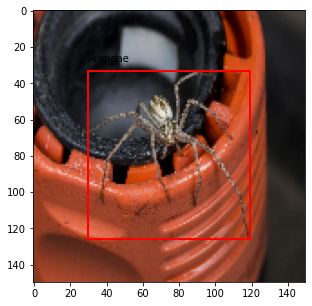

MODEL OUTPUT


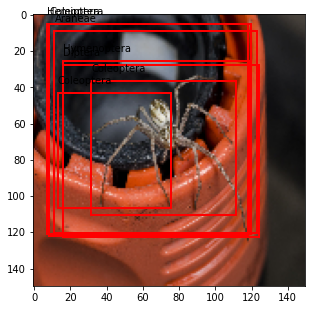

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


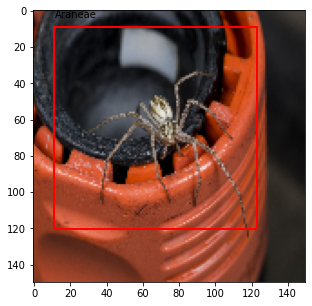

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

EXPECTED OUTPUT



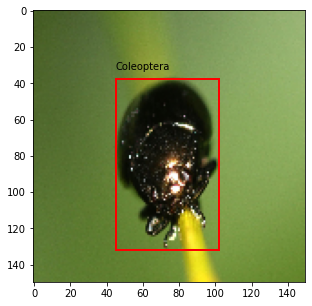

MODEL OUTPUT



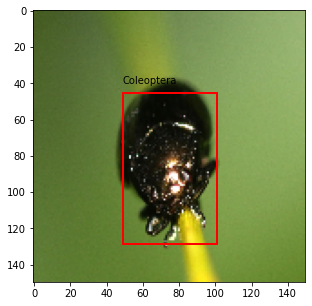

In [ ]:
#dataset_test = InsectImagesDataset(files_dir, 150, 150, transforms= get_transform(train=True))
# pick one image from the test set
img, target = dataset_test[35]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

### Checking overall accuracy on the test set

In [ ]:
# accuracy score of classification
correct = 0
for i in tqdm(range(len(dataset_test))):
  img, target = dataset_test[i]
# put the model in evaluation mode
  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])[0]
  nms_prediction = apply_nms(prediction, iou_thresh=0.01)
  try:
    if target['labels'][0].item()==nms_prediction['labels'][0].item():
      correct += 1
  except:
    print('void')
    
print(correct/len(dataset_test))  

 24%|██▍       | 731/3074 [22:26<1:16:20,  1.95s/it]

void


 38%|███▊      | 1155/3074 [35:37<55:16,  1.73s/it]

void


 81%|████████  | 2485/3074 [1:16:30<16:44,  1.70s/it]

void


100%|██████████| 3074/3074 [1:34:02<00:00,  1.84s/it]

0.6512687052700065


In [ ]:
# dictionary to count the accuracy for each class
count_dict = {}
for i in range(len(insect_classes)):
  count_dict[insect_classes[i]] = [0, 0, 0]
keys = list(count_dict.keys())

# accuracy score of classification
for i in tqdm(range(len(dataset_test))):
  img, target = dataset_test[i]
# put the model in evaluation mode
  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])[0]
  nms_prediction = apply_nms(prediction, iou_thresh=0.01)
  try:
    count_dict[keys[int(target['labels'][0].item())]][0] += 1
    if target['labels'][0].item()==nms_prediction['labels'][0].item():
      count_dict[keys[int(target['labels'][0].item())]][1] += 1
  except:
    print('void')

for i in range(len(keys)):
  if count_dict[keys[i]][0] != 0:
    count_dict[keys[i]][2] = round(count_dict[keys[i]][1] / count_dict[keys[i]][0], 3)
print(count_dict)


 24%|██▍       | 731/3074 [1:14:50<3:57:37,  6.09s/it]

void


 38%|███▊      | 1155/3074 [1:58:06<3:15:53,  6.12s/it]

void


 81%|████████  | 2485/3074 [4:12:41<57:43,  5.88s/it]

void


100%|██████████| 3074/3074 [5:12:01<00:00,  6.09s/it]

{'': [0, 0, 0], 'Araneae': [467, 355, 0.76], 'Coleoptera': [435, 384, 0.883], 'Diptera': [425, 144, 0.339], 'Hemiptera': [456, 255, 0.559], 'Hymenoptera': [411, 129, 0.314], 'Lepidoptera': [407, 326, 0.801], 'Odonata': [473, 409, 0.865]}


In [ ]:
for i in range(len(keys)):
  if count_dict[keys[i]][0] != 0:
    count_dict[keys[i]][2] = round(count_dict[keys[i]][1] / count_dict[keys[i]][0], 3)
print(count_dict)

{'': [0, 0, 0], 'Araneae': [64, 35, 0.547], 'Coleoptera': [89, 30, 0.337], 'Diptera': [74, 18, 0.243], 'Hemiptera': [72, 29, 0.403], 'Hymenoptera': [57, 12, 0.211], 'Lepidoptera': [64, 54, 0.844], 'Odonata': [80, 66, 0.825]}


In [9]:
l1 = [0, 0.547, 0.337, 0.243, 0.403, 0.211, 0.844, 0.825]
l2 = [0, 0.760, 0.883, 0.339, 0.559, 0.314, 0.801, 0.865]
insect_classes = [_, 'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata']
d1 = {}
d2 = {}
d = {}
for i in range(len(insect_classes)):
  d1[insect_classes[i]] = l1[i]
print(d1)
for i in range(len(insect_classes)):
  d2[insect_classes[i]] = l2[i]
print(d2)
for i in range(len(insect_classes)):
  d[insect_classes[i]] = [l1[i], l2[i]]
print(d)
d = pd.DataFrame(d)

{'': 0, 'Araneae': 0.547, 'Coleoptera': 0.337, 'Diptera': 0.243, 'Hemiptera': 0.403, 'Hymenoptera': 0.211, 'Lepidoptera': 0.844, 'Odonata': 0.825}
{'': 0, 'Araneae': 0.76, 'Coleoptera': 0.883, 'Diptera': 0.339, 'Hemiptera': 0.559, 'Hymenoptera': 0.314, 'Lepidoptera': 0.801, 'Odonata': 0.865}
{'': [0, 0], 'Araneae': [0.547, 0.76], 'Coleoptera': [0.337, 0.883], 'Diptera': [0.243, 0.339], 'Hemiptera': [0.403, 0.559], 'Hymenoptera': [0.211, 0.314], 'Lepidoptera': [0.844, 0.801], 'Odonata': [0.825, 0.865]}


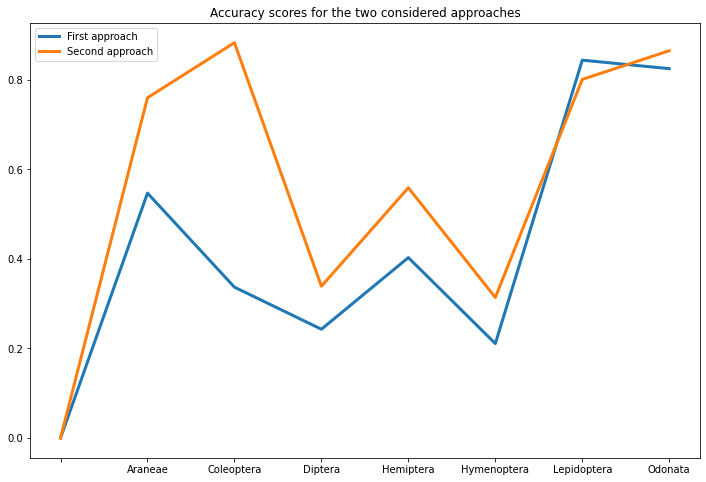

In [38]:
d.head()
x1, y1 = zip(*d1.items()) # unpack a list of pairs into two tuples
x2, y2 = zip(*d2.items()) # unpack a list of pairs into two tuples

fig = plt.figure(figsize=(12, 8))
plt.plot(x1, y1, lw=3, label='First approach')
plt.plot(x2, y2, lw=3, label='Second approach')
plt.title('Accuracy scores for the two considered approaches')
plt.legend()
plt.show()

### Improving the model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# use our dataset and defined transformations
dataset = InsectImagesDataset(files_dir, 150, 150, transforms= get_transform(train=True))
dataset_test = InsectImagesDataset(files_dir, 150, 150, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.05
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# Subset of train and test
#dataset = torch.utils.data.Subset(dataset, range(2000))
#dataset_test = torch.utils.data.Subset(dataset_test, range(500))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 8

# load a pre-trained model for classification and return
# only the features
#backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone = torchvision.models.densenet121(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1024 #9216(alexnet) #1000 #1024(densenet121, googlenet) #1280(mobilenet_v2, efficientnet_b7)

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), # (32, 64, 128, 256, 512)
                                   aspect_ratios=((0.5, 1.0, 2.0),)) # (0.5, 1.0, 2.0)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=8,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
# training for 10 epochs
num_epochs = 10
path_checkpoint = path + 'model.pt'


for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict()
            }, path_checkpoint)

### Exploring the features

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import scipy.misc

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),                  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [ ]:
image, target = dataset_test[1509]
#plt.imshow(image)

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.backbone.body.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

Total convolution layers: 49
conv_layers
Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])
49
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 128, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torc

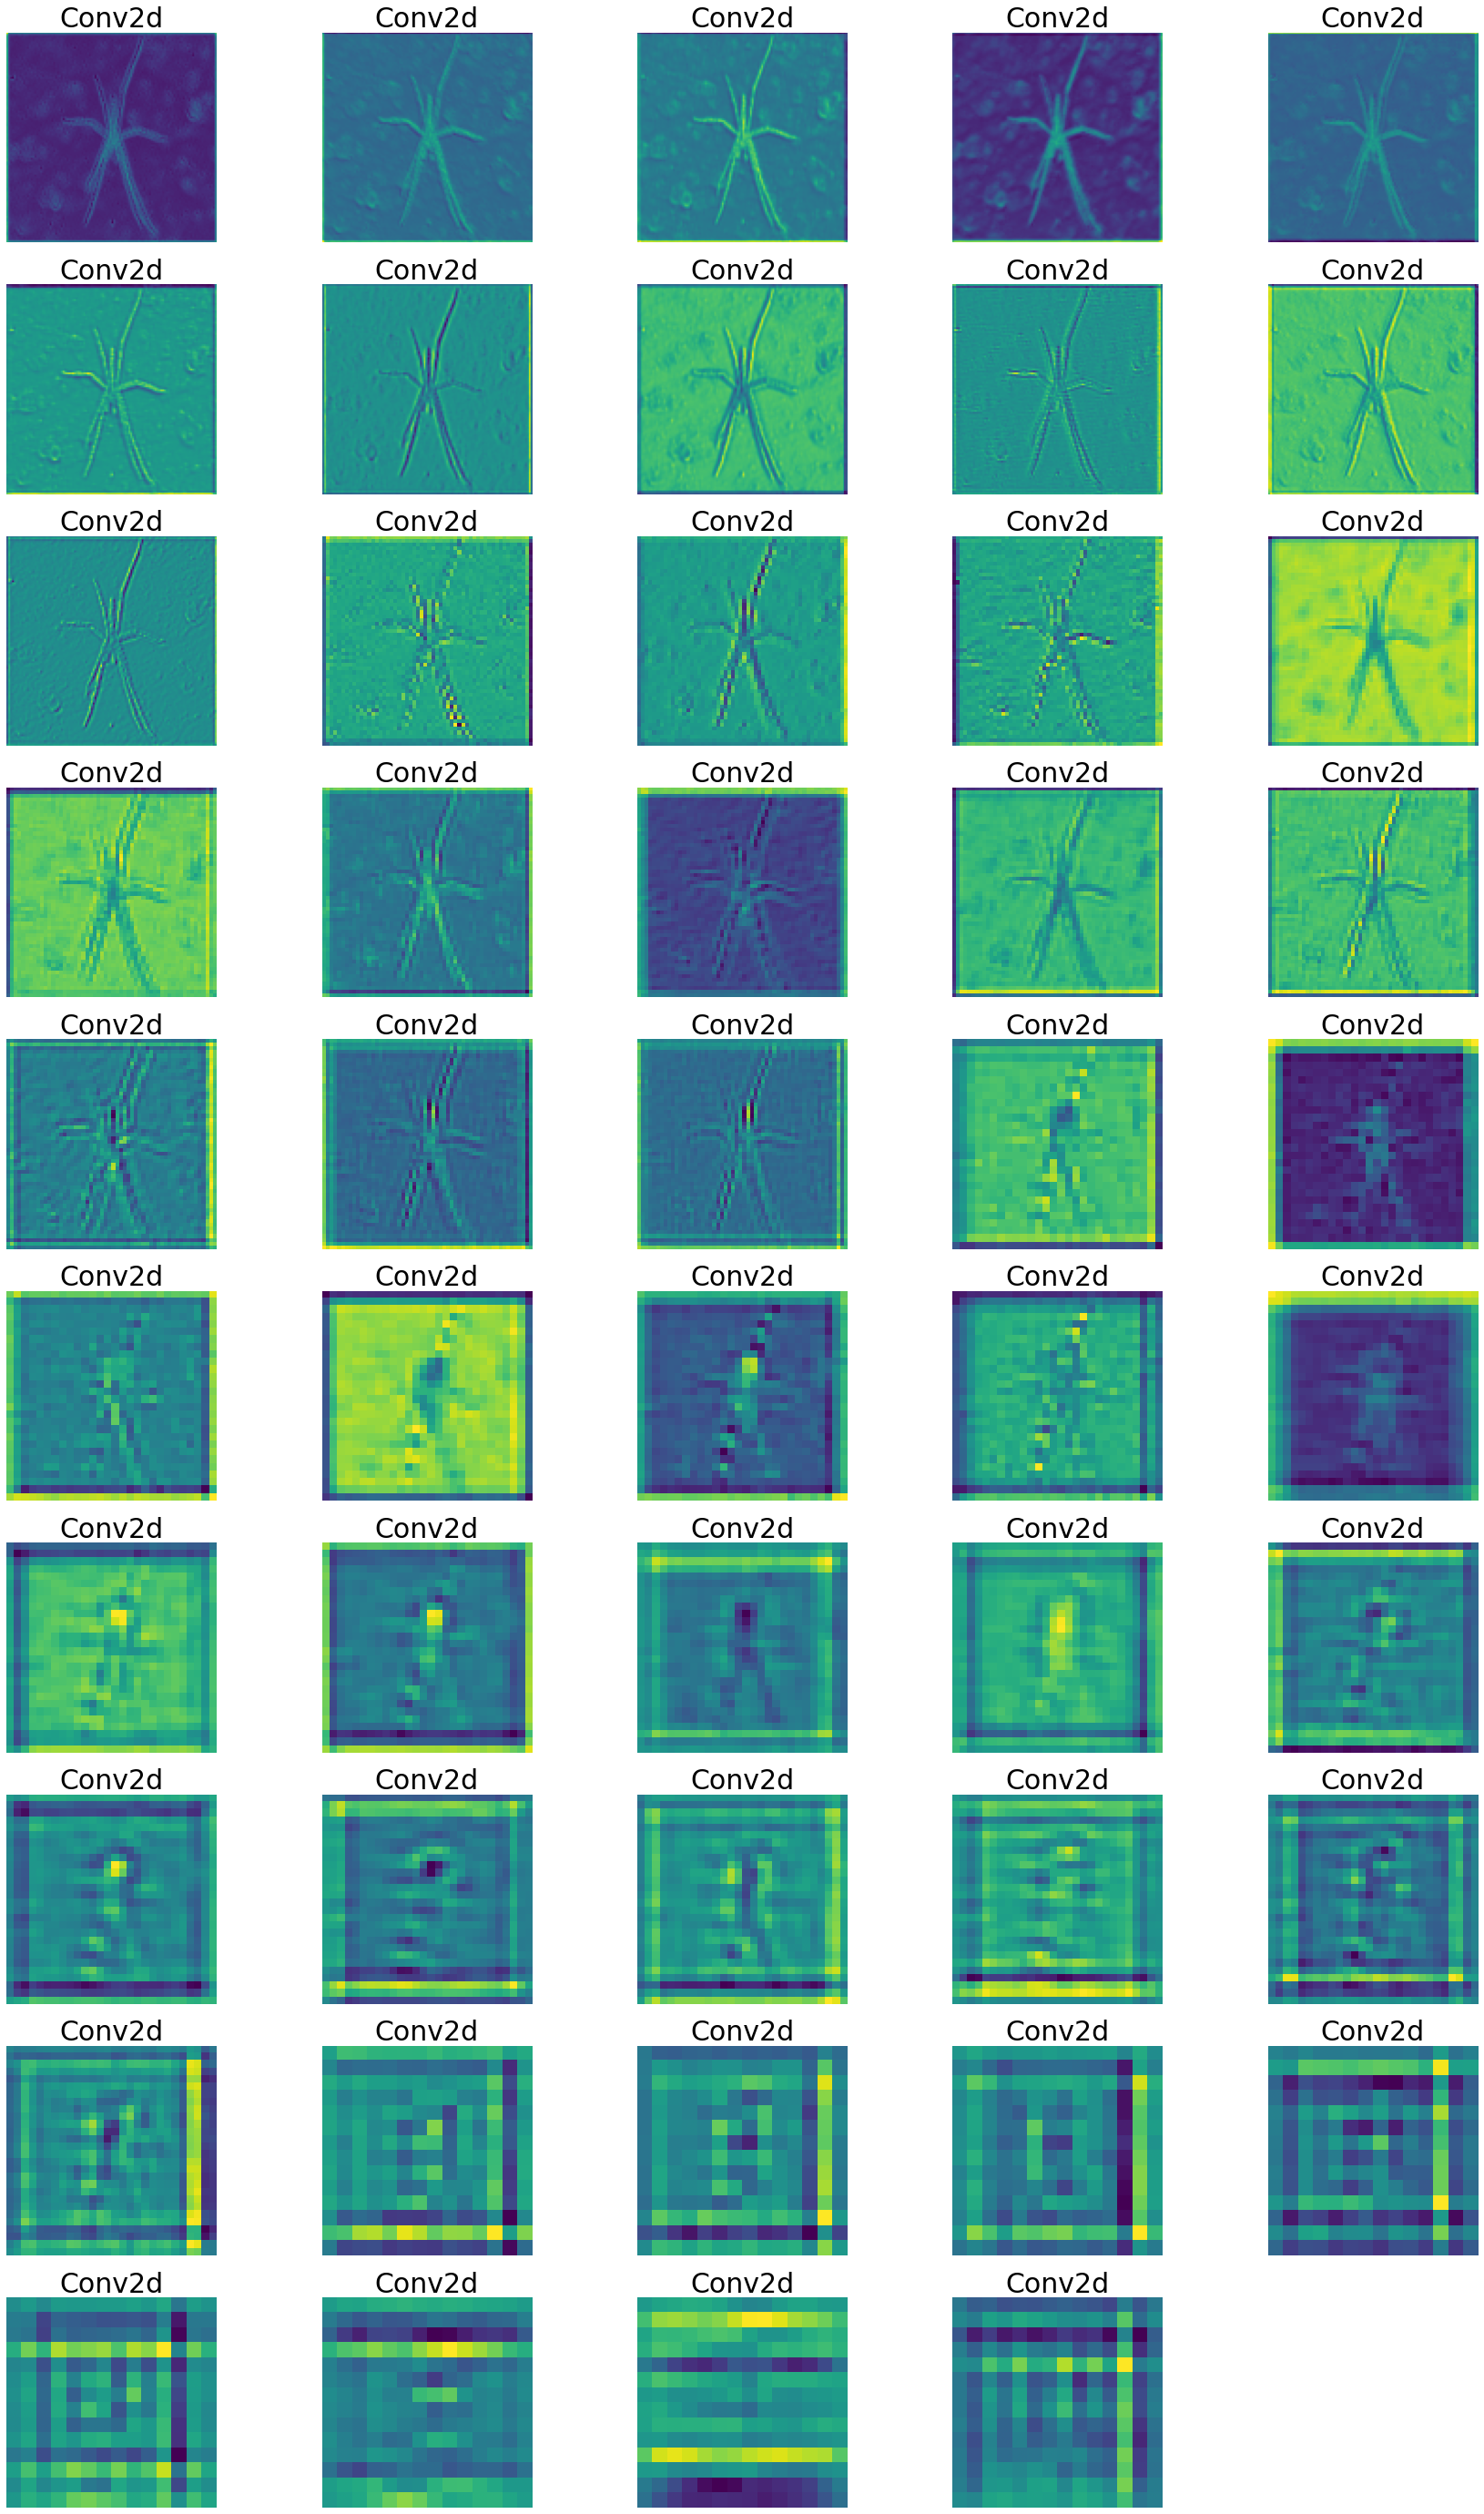

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(10, 5, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

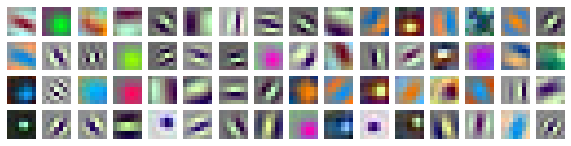

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(1, 65):
  fig.add_subplot(16, 16, i)
  img = np.array(model_weights[0][i-1].cpu().permute(1, 2, 0))
  img = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
  plt.imshow(img)
  plt.axis('off')
plt.show()